In [35]:
import msprime
import tskit
import numpy as np
import pandas as pd
import allel
import demes
import demesdraw
import seaborn as sns
sns.set_theme(style="whitegrid")
from IPython.display import SVG, set_matplotlib_formats
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 7]
#jupyter magic
%matplotlib inline
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Practical.10 - assessed class practical

You have **three** hours to complete this practical. You should aim to complete each of the four sections in ~ 45 minutes. Each section is worth 25 points. This practical assesses your understanding of the core data skills and population genetics concepts covered in PGA. 

**Please read each question carefully!** Some questions require writing or completing code, many simply ask you to write a couple of sentences to explain something. Please use the empty code cells provided for your answers. There are several code cells for multipart questions.

In [ ]:
#Be patient! Fetching the folder takes a minute or so!
! wget https://www.dropbox.com/s/k03vh2f1nq6ktyb/p10_data.tar.gz?dl=0 -q --show-progress -O p10_data.tar.gz
! tar zxf p10_data.tar.gz

# 10.1. Describing and interpreting genetic diversity

The code below imports variant data for $n=6$ individuals from the Southern Scare Swallowtail (*Iphiclides feisthamelii*) from a vcf file for chromosome 5 and summarizes biallelic variants in terms of an array of genotypes. 

**Note:** *I. feisthamelii* is the sister taxon of *I. podalirius* which we have analysed for the same chromosome in practical 4.

In [36]:
query_fields = ['samples', 'calldata/GT', 'variants/CHROM', 'variants/POS', 'variants/NUMALT']
vcf_f = "p10_data/iphiclides_podalirius.IP_504.chromosome_5.vcf.gz"
samplesIF =[ 'IF_RVcoll17B439','IF_RVcoll14B411', 'IF_142', 'IF_234.10X', 'IF_165', 'IF_236']

In [37]:
#It will take a few seconds to read the file, be patient ...
vcf_dict = allel.read_vcf(vcf_f, fields=query_fields, samples = samplesIF)
numalt_array = vcf_dict['variants/NUMALT']
mask_array = (numalt_array == 1)

In [ ]:
pos = vcf_dict['variants/POS'][mask_array]
snp_ga_IF = allel.GenotypeArray(vcf_dict['calldata/GT'])[mask_array]
#looking at the genotype array:
snp_ga_IF

<div class="alert alert-block alert-success">    
<b>Exercise 1 (6 points):</b>
    
- a) Compute the mean heterozygosity (per base) across these six <i>I. feisthamelii</i> individuals on chromosome 5.
- b) Given your estimate of per base heterozygosity, what fraction of 10kb windows sampled in a single individual genome would you expect to contain no heterozygous sites under the standard neutral coalescent?
    </div>

In [1]:
#SOL 1a)

In [2]:
#SOL 1b)

<div class="alert alert-block alert-success">    
<b>Exercise 2 (6 points):</b>
    
 - a) Estimate the mean pairwise genetic diversity (Tajima's $\pi$) across all sites on chromosome 5. 
 - b) How does $\pi$ compare to the mean heterozygosity computed in exercise 1? Name one process that may explain the difference between the two measures.
    </div>

In [3]:
#SOL 2a

In [4]:
#SOL 2b) (1-2 sentences)

<div class="alert alert-block alert-success">    
<b>Exercise 3 (3 points):</b>
    
- a) Assuming neutrality and a mutation rate of  $\mu =2.9 * 10^{-9}$ per base and generation  
 <a href='https://academic.oup.com/mbe/article/32/1/239/2925597'>(Keightley et al 2013)</a>, what value of effective population size $N_e$ does your estimate of $\pi$ correspond to? 
- b) How you could improve your estimate of $N_e$?
    </div>

In [5]:
#SOL 3a)

In [ ]:
#SOL 3b) (1-2 sentences)

<div class="alert alert-block alert-success">    
<b>Exercise 4 (10 points):</b>

- a) Use  <a href='https://scikit-allel.readthedocs.io/en/stable/stats/sf.html?highlight=sfs#allel.fold_sfsm' > `sfs_folded`</a> to compute the folded SFS for this sample of *I. feisthamelii* individuals and assign the result to a new variable `sfs_Ifei_array`.
     
- b) Visually compare the neutral expectation for the folded SFS `neutSFSFolded` (given in the code cell below) to your observation.
- c) Which entry of the SFS correponds to genealogical nodes that divide the sample into two subsets of equal size? 
- d) Name two population genetic processes that could explain the difference between the expected and the observed SFS? How would you assess the relative importance of these?
    </div>

In [6]:
#SOL 4a)

In [44]:
neutExp = np.array([1/i for i in range(1,2*sampleSize)])
neutExp /= neutExp.sum()
neutFlipped = np.flip(neutExp)
neutSFSFolded = neutExp + neutFlipped #sum them together for the 'folding'
neutSFSFolded = neutSFSFolded[0:sampleSize] 
neutSFSFolded[-1] = neutSFSFolded[-1]/2

In [7]:
#SOL 4b)

In [8]:
#SOL 4c) (one word answer)

In [9]:
#SOL 4d) (1-2 sentences)

# 10.2. Divergence

The code below loads the variant data for BOTH *I. podalirius* and *I. feisthamelii*, filters the data for biallelic sites and computes two population genetic summaries:

In [46]:
query_fields = ['samples', 'calldata/GT', 'variants/CHROM', 'variants/POS', 'variants/NUMALT']
vcf_f = "p10_data/iphiclides_podalirius.IP_504.chromosome_5.vcf.gz"

In [47]:
vcf_dict = allel.read_vcf(vcf_f, fields=query_fields)
numalt_array = vcf_dict['variants/NUMALT']
mask_array = (numalt_array == 1)
samples = vcf_dict['samples']

In [ ]:
specieslabel = [samplename.split('_')[0] for samplename in samples]
samples_df = pd.DataFrame({'samples':samples, 'taxon':specieslabel})
samples_df

In [49]:
pos = vcf_dict['variants/POS'][mask_array]
snp_ga = allel.GenotypeArray(vcf_dict['calldata/GT'])[mask_array]

In [50]:
ipod = samples_df[samples_df.taxon == 'IP'].index
ifei = samples_df[samples_df.taxon == 'IF'].index
ipod_counts = snp_ga.count_alleles(subpop = ipod, max_allele=1)
ifei_counts = snp_ga.count_alleles(subpop = ifei, max_allele=1)

<div class="alert alert-block alert-success">    
<b>Exercise 5 (17 points):</b>
    
 - a) Compute the mean pairwise diversity in *I. podalirius* and the per site divergence $d_{xy}$ between the two species. 
 - b) What is the net divergence $d_a$ between the two species?
 - c) What population split time (in years) does this value of $d_a$ correspond to? Assume 3 generations per year, the butterfly mutation rate mentioned in exercise 3 and a model of strict divergence without gene flow.    
 - d) Compare your estimate of the divergence time to that obtained by  <a href='https://onlinelibrary.wiley.com/doi/full/10.1111/mec.15981'>Ebdon et al 2021 (Table 1) </a> for the same pair of species using the same assumptions (and calibration) but analysing a different data partition. What could explain the difference in estimates? How would recent gene flow between the two species affect these estimates? 
    </div>

In [10]:
#SOL 5a)

In [11]:
#SOL 5b)

In [12]:
#SOL 5c)

In [13]:
#SOL 5d) (3-4 sentences)

<div class="alert alert-block alert-success">    
<b>Exercise 6 (8 points):</b>
    
 - a) Describe briefly what the two plots below show. How does the 2nd plot relate to the first?
 - b) What general conclusion about the speciation history of the two taxa can you draw? 
 - c) What processes could explain the outliers of extremely low values in the 2nd plot near the start of the chromosome (~ 0 Mb) and around position 13Mb?
    </div>

In [109]:
fst_ipod_ifei_wins, windows, counts = allel.windowed_patterson_fst(pos, ipod_counts, ifei_counts, size=50_000, start=0, stop=pos[-1])
wins1, windows, bases, counts = allel.windowed_diversity(pos, ipod_counts, size=50_000, start=0, stop=pos[-1])
wins2, windows, bases, counts = allel.windowed_diversity(pos, ifei_counts, size=50_000, start=0, stop=pos[-1])
wins3, windows, bases, counts = allel.windowed_divergence(pos, ipod_counts, ifei_counts, size=50_000, start=0, stop=pos[-1])
mid_point = windows.mean(axis=1)/1_000_000
window_stats = pd.DataFrame({'fst':fst_ipod_ifei_wins,'wins1':wins1,'wins2':wins2,'wins3':wins3, "coordinates":mid_point})

In [ ]:
fig, ax = plt.subplots(figsize=(18,3))
sns.lineplot(window_stats["coordinates"], window_stats["wins1"], label='wins1')
sns.lineplot(window_stats["coordinates"], window_stats["wins2"], label='wins2')
sns.lineplot(window_stats["coordinates"], window_stats["wins3"], label='wins3')
plt.xlabel('Mb')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(18,3))
sns.lineplot(window_stats["coordinates"], window_stats["fst"], label='differentiation')
plt.xlabel('Mb')
plt.ylabel('Fst')
plt.show()

In [ ]:
#SOL 6a) (3-4 sentences)

In [ ]:
#SOL 6b) (1 sentence)

In [ ]:
#SOL 6c) (2-3 sentences)

# 10.3. The effect of a selective sweep on a treesequence

When analysing real data, we can observe genetic variation but have no way of knowing the underlying treesequence directly. In contrast, when simulating population genomic data, we can directly examine the effect selection has on the ancestry at closely-linked sites.

<div class="alert alert-block alert-success">    
<b>Exercise 7 (25 points):</b> 
Examine the treesequence for the simulation of 40kb region below to see the effect of a single recent selective sweep on the tree sequence at neighbouring sites.

 - a) For this sample of four lineages, which node represents the common ancestor carrying the beneficial mutation?
 - b) What is the age of this node (<b>Hint:</b> the function `.node()` is your friend)? 
 - c) Is this node older or younger than the onset of the selective sweep?
 - d) What is the index of the first tree in which two lineages escape the sweep?
    </div>

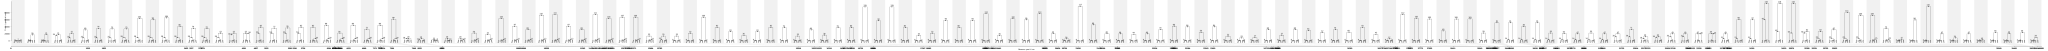

In [54]:
sweepModel2 = msprime.SweepGenicSelection(
    position = 0,
    start_frequency=1.0/(2*10_000), 
    end_frequency= 1 - 1.0/(2*10_000), 
    s=0.1,
    dt = 1/(40*10_000)
)

ts_sel2 = msprime.sim_ancestry(
    samples=2,
    model=[sweepModel2,msprime.StandardCoalescent()], #simulate the sweep first, followed by standard coal
    population_size=10_000,
    recombination_rate=1e-7,
    sequence_length=40_000,
    random_seed=1029384756
)

display(SVG(ts_sel2.draw_svg(y_axis=True,size=(16_000,400),y_ticks=[0,20_000,40_000,60_000,80_000])))

In [14]:
#SOL 7a) (one word answer)

In [ ]:
#SOL 7b)

In [ ]:
#SOL 7c) (one word answer)

In [ ]:
#SOL 7d) (one word answer)

# 10.4 Signatures of introgression

The code below imports and displays a plausible model of human history.

The demographic model includes the following events (in order, forward in time):
* An Ancestral population splits into Modern Humans (which remain in Africa) and Archaics, which leave Africa
* The Archaics split into Neanderthals and Denisovans
* Modern Humans split into Africans and Eurasians (which leave Africa)
* A pulse of gene flow occurs from Neanderthals into Eurasians (dashed arrow)
* Oceanians branch off from Eurasians to form a separate population
* A pulse of gene flow occurs from Denisovans into Oceanians (dashed arrow)

Note that solid arrows indicate population splits; dashed arrows indicate pulses of gene flow, with the direction indicated by the arrow.


In [ ]:
model_graph = demes.load("p10_data/Human_demography_simple.yaml")
demesdraw.tubes(model_graph, log_time=True, max_time=1e5,
               positions = {"Ancestral":2e5, "Modern_Humans":1e5,
                            "Africans":0.5e5, "Out_of_Africans": 2e5, "Oceanians":1.5e5, "Eurasians":2.5e5,
                            "Neanderthals":3e5, "Archaics":3.5e5, "Denisovans":4e5})
plt.show()

The code below simulates a treesequence for 20 Mb of genome from the above scenario, sampling one haploid genome each from Africans ("Afr"), Oceanians ("Oce") and Denisovans ("Den").

The next block of code computes and plots the genomic span (in bp) of each tree in thr treesequence, separated into the three possible topologies:
* (Den,(Afr,Oce));
* (Oce,(Afr,Den));
* (Afr,(Oce,Den));

In [17]:
#This simulation will take a few moments
ts = msprime.sim_ancestry(samples={"Africans": 1, "Oceanians":1, "Denisovans":1},
                          demography=msprime.Demography.from_demes(model_graph),
                          sequence_length = 20e6, recombination_rate=1e-8, ploidy=1,
                          random_seed=3, record_provenance=False) 
#record_provenance=False just saves a little bit of memory

In [ ]:
tskit_rankID_to_nwk = {}

for t in tskit.all_trees(3):
    ID = t.rank()
    nwk_string = t.newick(node_labels={0: "Afr", 1: "Oce", 2: "Den"}, include_branch_lengths=False)
    tskit_rankID_to_nwk[ID]=nwk_string

# Record the topology and span of each unique genealogy
# Note that here we are summing the spans of adjacent trees if they have the same topology
tree_data = {"span":[], "topology":[]}
previous_topology=""
for i,tree in enumerate(ts.trees()):
    ID = tree.rank()
    topology = tskit_rankID_to_nwk[ID]
    if topology != previous_topology:
        tree_data["span"].append(tree.span)
        tree_data["topology"].append(topology)
    else:
        tree_data["span"][-1] += tree.span
    previous_topology=topology


tree_data = pd.DataFrame(tree_data)

#Plots the tree spans
sns.stripplot(x="topology", y="span", data=tree_data, jitter=True, alpha=0.5)
plt.show()

<div class="alert alert-block alert-success">    
    <b>Exercise 8 (10 points):</b>

* Explain why the spans of genealogies with these three topologies have different distributions in the light of the demographic model shown above. **[Word limit: 200]**

</div>

In [ ]:
#SOL [Word limit: 200]

The code below simulates sequence data under the above dempgraphic model, with a single haploid sequence from each of five populations: Africans ("Afr"), Oceanians ("Oce"), Eurasians ("Eur"), Neanderthals ("Nea"), Denisovans ("Den").

To increase speed, we simulate 200 short sequence blocks of 1 Mb each, and then concatenate them.

In [22]:
#This simulation will take a few moments
ts_list = msprime.sim_ancestry(samples={"Africans": 1, "Oceanians": 1, "Eurasians":1, "Neanderthals":1, "Denisovans":1},
                          demography=msprime.Demography.from_demes(model_graph),
                          sequence_length = 1e6, recombination_rate=1e-8, ploidy=1,
                          num_replicates=200, random_seed=1, record_provenance=False) #record_provenance=False just saves a little bit of memory

mts_list = [msprime.sim_mutations(ts, rate=1e-8, random_seed=1) for ts in ts_list]

In [ ]:
#Generate concatenated sequences
haplotypes = pd.DataFrame(np.concatenate([mts.genotype_matrix() for mts in mts_list]))
haplotypes = haplotypes.rename({0:'Afr', 1:'Oce', 2:'Eur', 3:'Nea', 4:'Den'}, axis=1)
haplotypes

The code below defines functions to compute introgression statistics from single haploid sequences: the number of "ABBA" and "BABA" sites, the *D* statistic, and an estimator of the proportion of introgression (*f*).

The next code block computes these statistics to examine introgression from Neanderthals into Eurasians, and from Denisovans into Eurasians.

In [26]:
def get_ABBA(haplotypes, P1, P2, P3):
    return np.all(haplotypes[[P1, P2, P3]] == [0,1,1], axis=1).sum()

def get_BABA(haplotypes, P1, P2, P3):
    return np.all(haplotypes[[P1, P2, P3]] == [1,0,1], axis=1).sum()

def get_D(haplotypes, P1, P2, P3):
    ABBAsum = get_ABBA(haplotypes, P1, P2, P3)
    BABAsum = get_BABA(haplotypes, P1, P2, P3)
    return (ABBAsum - BABAsum) / (ABBAsum + BABAsum)

def get_f(haplotypes, P1, P2, P3):
    ABBAsum = get_ABBA(haplotypes, P1, P2, P3)
    BABAsum = get_BABA(haplotypes, P1, P2, P3)
    
    ABBA_possible_sum = np.all(haplotypes[[P1,P3]] == [0,1], axis=1).sum()
    BABA_possible_sum = 0
    
    return (ABBAsum - BABAsum) / (ABBA_possible_sum - BABA_possible_sum)

In [ ]:
print("Testing for intogression from Neanderthals into Eurasians")
P1, P2, P3 = "Afr", "Eur", "Nea"
print("ABBA:", get_ABBA(haplotypes, P1, P2, P3))
print("BABA:", get_BABA(haplotypes, P1, P2, P3))
print("D:", get_D(haplotypes, P1, P2, P3))
print("f:", get_f(haplotypes, P1, P2, P3))

In [ ]:
print("Testing for intogression from Denisovans into Eurasians")
P1, P2, P3 = "Afr", "Eur", "Den"
print("ABBA:", get_ABBA(haplotypes, P1, P2, P3))
print("BABA:", get_BABA(haplotypes, P1, P2, P3))
print("D:", get_D(haplotypes, P1, P2, P3))
print("f:", get_f(haplotypes, P1, P2, P3))

<div class="alert alert-block alert-success">    
    <b>Exercise 9 (5 points):</b>

* Given that the sequence data was simulated under the model above, in which there is no gene flow from Denisovans into Eurasians, explain why there is still a detectable signal of apparent introgression (assume that this is a significant signal and not simply caused by stochastic noise) **[Word limit: 100]**. 

</div>

In [ ]:
#SOL [Word limit: 100]

In [ ]:
model_graph = demes.load("p10_data/Human_demography_simple_alternative.yaml")

demesdraw.tubes(model_graph, log_time=True, max_time=1e5,
               positions = {"Ancestral":2e5, "Modern_Humans":1e5,
                            "Africans":0.5e5, "Out_of_Africans": 2e5, "Oceanians":1.5e5, "Eurasians":2.5e5,
                            "Neanderthals":3e5, "Archaics":3.5e5, "Denisovans":4e5})
plt.show()

In [33]:
ts_list = msprime.sim_ancestry(samples={"Africans": 1, "Oceanians": 1, "Eurasians":1, "Neanderthals":1, "Denisovans":1},
                          demography=msprime.Demography.from_demes(model_graph),
                          sequence_length = 1e6, recombination_rate=1e-8, ploidy=1,
                          num_replicates=200, random_seed=1, record_provenance=False) #record_provenance=False just saves a little bit of memory

mts_list = [msprime.sim_mutations(ts, rate=1e-8, random_seed=2) for ts in ts_list]

haplotypes = pd.DataFrame(np.concatenate([mts.genotype_matrix() for mts in mts_list]))

haplotypes = haplotypes.rename({0:'Afr', 1:'Oce', 2:'Eur', 3:'Nea', 4:'Den'}, axis=1)

In [ ]:
print("Testing for intogression from Neanderthals into Eurasians")
P1, P2, P3 = "Afr", "Eur", "Nea"
print("ABBA:", get_ABBA(haplotypes, P1, P2, P3))
print("BABA:", get_BABA(haplotypes, P1, P2, P3))
print("D:", get_D(haplotypes, P1, P2, P3))
print("f:", get_f(haplotypes, P1, P2, P3))

<div class="alert alert-block alert-success">    
    <b>Exercise 10 (10 points):</b>

* Explain why, under this alternative demographic model, the *D* statistic value is much larger, whereas the estimated *f* value is very similar to that under the original model. Note that the **only** change in this alternative demographic model is the bottleneck in the Modern Humans before the split that gives rise to Africans and Out_of_Africans. **[Word limit: 250]**

</div>

In [1]:
#SOL [Word limit: 250]